# <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Closed-Loop Stability Analysis with Bairstow Method</span>

### <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Import libraries</span>

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

## <span style="font-family: 'Times New Roman'; font-size: 24px; font-weight: bold;">Tools</span>

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Bairstow Method</span>

### <span style="font-family: 'Times New Roman'; font-size: 14px;">This function finds the roots of the chracteristic polynomial of the control loop</span>

In [2]:
def bairstow(coefficients : list, r_guess:float=1, s_guess:float=1, tol:float=1e-10, max_iter:int=100):
    """
    Approximate roots of a polynomial equation using the Bairstow numerical method.

    Parameters:
    a (list or numpy.array): A list of coefficients representing the polynomial equation in descending order of powers,
                             where a[0] is the coefficient of x^n, a[1] is the coefficient of x^(n-1), and so on.
    r_guess (float, optional): Initial guess (default is 1).
    s_guess (float, optional): Initial guess (default is 1).
    tol (float, optional): Tolerance level for the residual term (default is 1e-10).
    max_iter (int, optional): Maximum number of iterations (default is 100).

    Returns:
    (numpy.array): A list of approximate roots of the polynomial equation.

    Raises:
    Exception: If the method fails to converge within the specified maximum number of iterations.
    """
    np.random.seed(int(time.time()))
    a = coefficients.copy()
    a = np.array(a, dtype='float')
    a = a[: : -1] # for simplifying the implementation
    a = a / a[-1] # to make sure that the coefficent of x^n is equal to 1
    n = len(a) - 1
    roots = []
    r, s = r_guess, s_guess
    rr, ss = r, s

    # main loop
    counter_2 = 0
    while n > 2:
        # step 1: pre-processing
        a = a / a[-1] # to make sure that the coefficent of x^n is equal to 1

        # step 2: initialize the algorithm
        n = len(a) - 1

        b = np.zeros(n-1)
        b_ = np.zeros(3)

        c = np.zeros(n-1)
        c_ = np.zeros(4)

        # main loop to find 2 roots
        counter = 0
        while counter < max_iter:
            # calculate b coefficients
            b[n-2] = a[n]
            b[n-3] = a[n-1] + r * b[n-2]
            for k in range(n, 3, -1):
                b[k-4] = a[k-2] + r * b[k-3] + s * b[k-2]
            b_[1] = a[1] + r * b[0] + s * b[1]
            b_[2] = a[0] + r * b_[1] + s * b[0]

            if abs(b_[1]) >= 100 and abs(b_[2]) >= 100 :
              r, s = np.random.randn(2)

            # calculate c coefficients
            c[n-2] = 0
            c[n-3] = 0
            for k in range(n, 3, -1):
                c[k-4] = b[k-2] + r * c[k-3] + s * c[k-3]
            c_[1] = b[1] + r * c[0] + s * c[1]
            c_[2] = b[0] + r * c_[1] + s * c[0]
            c_[3] = b_[1] + r * c_[2] + s * c_[1]

            # check if the residual term is acceptale
            if abs(b_[1]) < tol and abs(b_[2]) < tol:
                r, s = float(r), float(s)
                x1 = (r + (r**2 + 4 * s)**0.5) / 2
                x2 = (r - (r**2 + 4 * s)**0.5) / 2

                roots.append(x1)
                roots.append(x2)
                a = b
                n -= 2
                #r, s = r_guess, s_guess
                rr, ss = r, s
                counter_2 = 0
                break

            # calculate new r and s
            delta_r = (c_[1] * b_[2] - c_[2] * b_[1]) / (c_[2]**2 - c_[1] * c_[3])
            delta_s = (c_[3] * b_[1] - c_[2] * b_[2]) / (c_[2]**2 - c_[1] * c_[3])
            r = r + delta_r
            s = s + delta_s
            counter += 1

        if counter >= max_iter and counter_2 < max_iter:
            # this part increases the variance of the normal distribution gradually to find suitable initial guesses for r and s
            r = np.random.normal(loc=rr, scale=5, size=1)
            s = np.random.normal(loc=ss, scale=5, size=1)
            #r, s = r, s = np.round(np.random.randn(2), 5)
            counter_2 += 1

        elif counter >= max_iter and counter_2 >= max_iter:
            raise Exception(
                "No roots found. Try new intial guesses or change the tolerance and maximum iterations")

    if n == 2:
        x1 = (-a[1] + (a[1]**2 - 4 * a[0])**0.5) / 2
        x2 = (-a[1] - (a[1]**2 - 4 * a[0])**0.5) / 2
        roots.append(x1)
        roots.append(x2)
        return np.array(roots)

    if n == 1:
        x1 = -a[0]
        roots.append(x1)
        return np.array(roots)

## <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Modeling</span>

<div style="display: flex; justify-content: center;">
    <img src="loop.png" alt="Logo" style="width:600px; height:200px;"/>
</div>

<span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Characteristic Equation of the Control Loop</span>

<span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Characteristic Eq.</span> &emsp;   <span style="font-family: Arial; font-size: 20px;">$$1 + C(s)G(s)H(s) = 0$$</span>

<span style="font-family: Arial; font-size: 20px;">$$1 + K_c (1 + \frac{1}{\tau_Is})(\frac{3 \alpha}{5 \beta s + 1})(\frac{\beta s^{2} + 4 \beta s + 5}{\alpha s^{s} + 5 \alpha s^{4} + 2.5 \alpha \beta s^{3 } + 30 \beta s + 5})(\frac{e^{-3s}}{\beta s + 1}) = 0$$</span>

\
<span style="font-family: 'Times New Roman'; font-size: 18px; font-weight: bold;">First order Pade approximation: </span> &emsp; <span style="font-family: Arial; font-size: 20px;">$e^{-\tau_d s} = \frac{1 - 0.5 \tau_d s}{1 + 0.5 \tau_d s}$</span>

<span style="font-family: 'Times New Roman'; font-size: 18px;">Applynig Pade approximation and simplifying the equation,</span> \
\
\
<span style="font-family: Arial; font-size: 16px;">
$$ 1 + K_c \frac{3 \alpha \beta \tau_I s^{3} + (12 \alpha \beta \tau_I + 12 \alpha \beta) s^{2} + (15 \alpha \tau_I + 12 \alpha \beta) s + 15 \alpha}{[(2.5 \alpha \beta^{2}) \tau_I s^{9} + (17.5 \alpha \beta^{2} + 3 \alpha \beta) \tau_I s^{8} + (6.25 \alpha \beta^{3} + 25 \alpha \beta^{2} + 9 \alpha \beta + 0.5 \alpha) \tau_I s^{7} + (30 \alpha \beta^{3} + 7.5 \alpha \beta^{2} + 30 \alpha \beta + 3.5 \alpha) \tau_I s^{6} + (75 \beta^{3} + 35 \alpha \beta^{3} + 36 \alpha \beta^{2} + 1.25 \alpha \beta + 5 \alpha) \tau_I s^{5} + (150 \beta^{3} + 95 \beta^{2} + 42 \alpha \beta^{2} + 6 \alpha \beta) \tau_I s^{4} + (190 \beta^{2} + 21 \beta + 7 \alpha \beta) \tau_I s^{3} + 42 \beta + 1) \tau_I s^{2} + (2) \tau_I s]} = 0$$
</span>

\
\
<span style="font-family: Arial; font-size: 16px;">
$$\frac{[(2.5 \alpha \beta^{2}) \tau_I s^{9} + (17.5 \alpha \beta^{2} + 3 \alpha \beta) \tau_I s^{8} + (6.25 \alpha \beta^{3} + 25 \alpha \beta^{2} + 9 \alpha \beta + 0.5 \alpha) \tau_I s^{7} + (30 \alpha \beta^{3} + 7.5 \alpha \beta^{2} + 30 \alpha \beta + 3.5 \alpha) \tau_I s^{6} + (75 \beta^{3} + 35 \alpha \beta^{3} + 36 \alpha \beta^{2} + 1.25 \alpha \beta + 5 \alpha) \tau_I s^{5} + (150 \beta^{3} + 95 \beta^{2} + 42 \alpha \beta^{2} + 6 \alpha \beta) \tau_I s^{4} + (190 \beta^{2} + 21 \beta + 7 \alpha \beta + 3 \alpha \beta K_c) \tau_I s^{3} + ((42 \beta + 12 \alpha \beta K_c + 1) \tau_I + 12 \alpha \beta K_c) s^{2} + ((15 \alpha K_c + 2)\tau_I + 12 \alpha \beta K_c) s + 15 \alpha K_c]}{[(2.5 \alpha \beta^{2}) \tau_I s^{9} + (17.5 \alpha \beta^{2} + 3 \alpha \beta) \tau_I s^{8} + (6.25 \alpha \beta^{3} + 25 \alpha \beta^{2} + 9 \alpha \beta + 0.5 \alpha) \tau_I s^{7} + (30 \alpha \beta^{3} + 7.5 \alpha \beta^{2} + 30 \alpha \beta + 3.5 \alpha) \tau_I s^{6} + (75 \beta^{3} + 35 \alpha \beta^{3} + 36 \alpha \beta^{2} + 1.25 \alpha \beta + 5 \alpha) \tau_I s^{5} + (150 \beta^{3} + 95 \beta^{2} + 42 \alpha \beta^{2} + 6 \alpha \beta) \tau_I s^{4} + (190 \beta^{2} + 21 \beta + 7 \alpha \beta) \tau_I s^{3} + (42 \beta + 1) \tau_I s^{2} + (2) \tau_I s]} = 0$$
</span>

<span style="font-family: 'Times New Roman'; font-size: 18px; font-weight: bold;">Coefficients of the polynomial:</span> \
<span style="font-family: Arial; font-size: 16px;">
**$S^{9}$:**   &emsp;   $(7.5 \alpha \beta^{2}) \tau_I$ \
**$S^{8}$:**   &emsp;   $(42.5 \beta^{2} + 9 \beta) \alpha \tau_I$ \
**$S^{7}$:**   &emsp;   $(51 \beta + 1.5 + 25 \beta^{2} + 18.75 \beta^{3}) \alpha \tau_I$ \
**$S^{6}$:**   &emsp;   $(8.5 + 30 \beta+ 22.5 \beta^{2} + 65 \beta^{3}) \alpha \tau_I$ \
**$S^{5}$:**   &emsp;   $(5 + 78 \beta^{2} + 3.75 \beta + 35 \beta^{3}) \alpha \tau_I + (225 \beta^{3} \tau_I)$ \
**$S^{4}$:**   &emsp;   $(13 \beta + 42 \beta^{2} - 4.5 K_c \beta) \alpha \tau_I + (285 + 150 \beta) \beta^{2} \tau_I$ \
**$S^{3}$:**   &emsp;   $(7 \alpha + 190 \beta + 63 - 15 K_c \alpha) \beta \tau_I - 4.5 K_c \alpha \beta$ \
**$S^{2}$:**   &emsp;   $(42 \beta + 12 \alpha \beta K_c + 3) \tau_I - 15 \alpha \beta K_c - 22.5 K_c \alpha \tau_I$ \
**$S^{1}$:**   &emsp;   $(15 \alpha K_c + 2) \tau_I + 12 \alpha \beta K_c - 22.5 K_c \alpha$  \
**$S^{0}$:**   &emsp;   $(15 \alpha K_c)$
</span>

<span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Calculate $\alpha$ and $\beta$</span>

<span style="font-family: 'Times New Roman'; font-size: 18px; font-weight: bold;">Student Numbers:</span> \
&emsp; <span style="font-family: 'Times New Roman'; font-size: 18px;">


$\alpha$ and $\beta$  $\gamma$: \
    $$\alpha = 5.0$$
    $$\beta = 2.0$$
</span>

In [3]:
alpha = 5.8
beta = 2.0

# values of Kc and tau
K_c = np.array([0.1, 0.5, 2.5, 10, 25, 50]) * alpha
tau = np.array([0.1, 0.2, 0.3, 0.5, 0.8, 1.0])

# a dictonaty for sacving the results
results = dict()

## <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Main Code</span>

<span style="font-family: 'Times New Roman'; font-size: 18px;">
Calculating the poles of the control loop for different values of $K_c$ and $\tau$
</span>


In [4]:
t1 = time.time()
for Kc in K_c:
    result_tmp = dict()

    for tau_i in tau:
        coeff = [
            (7.5 * alpha * beta**2) * tau_i,
            (42.5 * beta**2 + 9 * beta) * alpha * tau_i,
            (51 * beta + 1.5 + 25 * beta**2 + 18.75 * beta**3) * alpha * tau_i,
            (8.5 + 30 * beta+ 22.5 * beta**2 + 65 * beta**3) * alpha * tau_i,
            (5 + 78 * beta**2 + 3.75 * beta + 35 * beta**3) * alpha * tau_i + (225 * beta**3 * tau_i),
            (13 * beta + 42 * beta**2 - 4.5 * Kc * beta) * alpha * tau_i + (285 + 150 * beta) * beta**2 * tau_i,
            (7 * alpha + 190 * beta + 63 - 15 * Kc * alpha) * beta * tau_i - 4.5 * Kc * alpha * beta,
            (42 * beta + 12 * alpha * beta * Kc + 3) * tau_i - 15 * alpha* beta * Kc - 22.5 * Kc * alpha * tau_i,
            (15 * alpha * Kc + 2) * tau_i + 12 * alpha * beta * Kc - 22.5 * Kc * alpha,
            15 * alpha * Kc,
        ]
        poles = bairstow(coeff, r_guess=-1, s_guess=-1, tol=1e-10, max_iter=1500)
        result_tmp[tau_i] = poles

        print(f"Kc = {Kc},   tau_i = {tau_i}")
        print("poles = ", poles)
        print("-" * 60)

    results[Kc] = result_tmp

t2 = time.time()

print("Finished successfully")
print("Runtime: ", round((t2-t1)/60, 3), "min")

C:\Users\sardaar\AppData\Local\Temp\ipykernel_8552\2149007699.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b[n-3] = a[n-1] + r * b[n-2]
C:\Users\sardaar\AppData\Local\Temp\ipykernel_8552\2149007699.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b[k-4] = a[k-2] + r * b[k-3] + s * b[k-2]
C:\Users\sardaar\AppData\Local\Temp\ipykernel_8552\2149007699.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_[1] = a[1] + r * b[0] + s * b[1]
C:\Users\sardaar\A

Kc = 0.58,   tau_i = 0.1
poles =  [-0.77507294+0.j         -1.14097962+0.j          0.4231033 +0.29297589j
  0.4231033 -0.29297589j -0.54785431+0.81513116j -0.54785431-0.81513116j
  0.18309228+1.68518355j  0.18309228-1.68518355j -4.46729665+0.j        ]
------------------------------------------------------------
Kc = 0.58,   tau_i = 0.2
poles =  [ 0.34830473+0.27976179j  0.34830473-0.27976179j -0.77484531+0.j
 -1.03019051+0.j         -0.50888796+0.67382695j -0.50888796-0.67382695j
  0.16332749+1.68251118j  0.16332749-1.68251118j -4.46711935+0.j        ]
------------------------------------------------------------
Kc = 0.58,   tau_i = 0.3
poles =  [ 0.30917544+0.26986449j  0.30917544-0.26986449j -0.77455315+0.j
 -0.96866492+0.j         -0.49386715+0.5968486j  -0.49386715-0.5968486j
  0.15649753+1.68200599j  0.15649753-1.68200599j -4.46706024+0.j        ]
------------------------------------------------------------
Kc = 0.58,   tau_i = 0.5
poles =  [-0.7736271 +0.j         -0.89218211+0

C:\Users\sardaar\AppData\Local\Temp\ipykernel_8552\2149007699.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c[k-4] = b[k-2] + r * c[k-3] + s * c[k-3]
C:\Users\sardaar\AppData\Local\Temp\ipykernel_8552\2149007699.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c_[1] = b[1] + r * c[0] + s * c[1]
C:\Users\sardaar\AppData\Local\Temp\ipykernel_8552\2149007699.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c_[2] = b[0] + r * c_[1] + s * c[0]
C:\Users\sa

Kc = 2.9,   tau_i = 0.5
poles =  [-0.77497724+0.j         -1.05289495+0.j          0.44155452+0.30756884j
  0.44155452-0.30756884j -0.6095263 +0.74643816j -0.6095263 -0.74643816j
  0.18190601+1.71047345j  0.18190601-1.71047345j -4.46666294+0.j        ]
------------------------------------------------------------
Kc = 2.9,   tau_i = 0.8
poles =  [-0.77449418+0.j         -0.92791791+0.j         -0.61118858+0.62861561j
 -0.61118858-0.62861561j  0.39377359+0.3065738j   0.39377359-0.3065738j
  0.16855265+1.70910295j  0.16855265-1.70910295j -4.46652989+0.j        ]
------------------------------------------------------------
Kc = 2.9,   tau_i = 1.0
poles =  [ 0.37300347+0.30583173j  0.37300347-0.30583173j -0.77346146+0.j
 -0.85598148+0.j         -0.6223792 +0.57252944j -0.6223792 -0.57252944j
  0.16400664+1.70881842j  0.16400664-1.70881842j -4.46648554+0.j        ]
------------------------------------------------------------
Kc = 14.5,   tau_i = 0.1
poles =  [-1.04230652+1.53645406j -1.04230

C:\Users\sardaar\AppData\Local\Temp\ipykernel_8552\2149007699.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r, s = float(r), float(s)


Kc = 14.5,   tau_i = 0.2
poles =  [-0.77523957+0.j         -1.5654453 +0.j          0.8154972 +0.16566997j
  0.8154972 -0.16566997j -0.92823316+1.32321478j -0.92823316-1.32321478j
  0.38353125+1.88377063j  0.38353125-1.88377063j -4.46757239+0.j        ]
------------------------------------------------------------
Kc = 14.5,   tau_i = 0.3
poles =  [-0.7752294 +0.j         -1.43773339+0.j          0.7560501 +0.22955848j
  0.7560501 -0.22955848j -0.87889176+1.19451511j -0.87889176-1.19451511j
  0.32903748+1.8513714j   0.32903748-1.8513714j  -4.46609553+0.j        ]
------------------------------------------------------------
Kc = 14.5,   tau_i = 0.5
poles =  [-0.77520118+0.j         -1.2600092 +0.j          0.68858763+0.27617251j
  0.68858763-0.27617251j -0.84471242+1.02734497j -0.84471242-1.02734497j
  0.27285276+1.82762417j  0.27285276-1.82762417j -4.46491223+0.j        ]
------------------------------------------------------------
Kc = 14.5,   tau_i = 0.8
poles =  [ 0.63425398+0.303757

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Visualizing the Results</span>

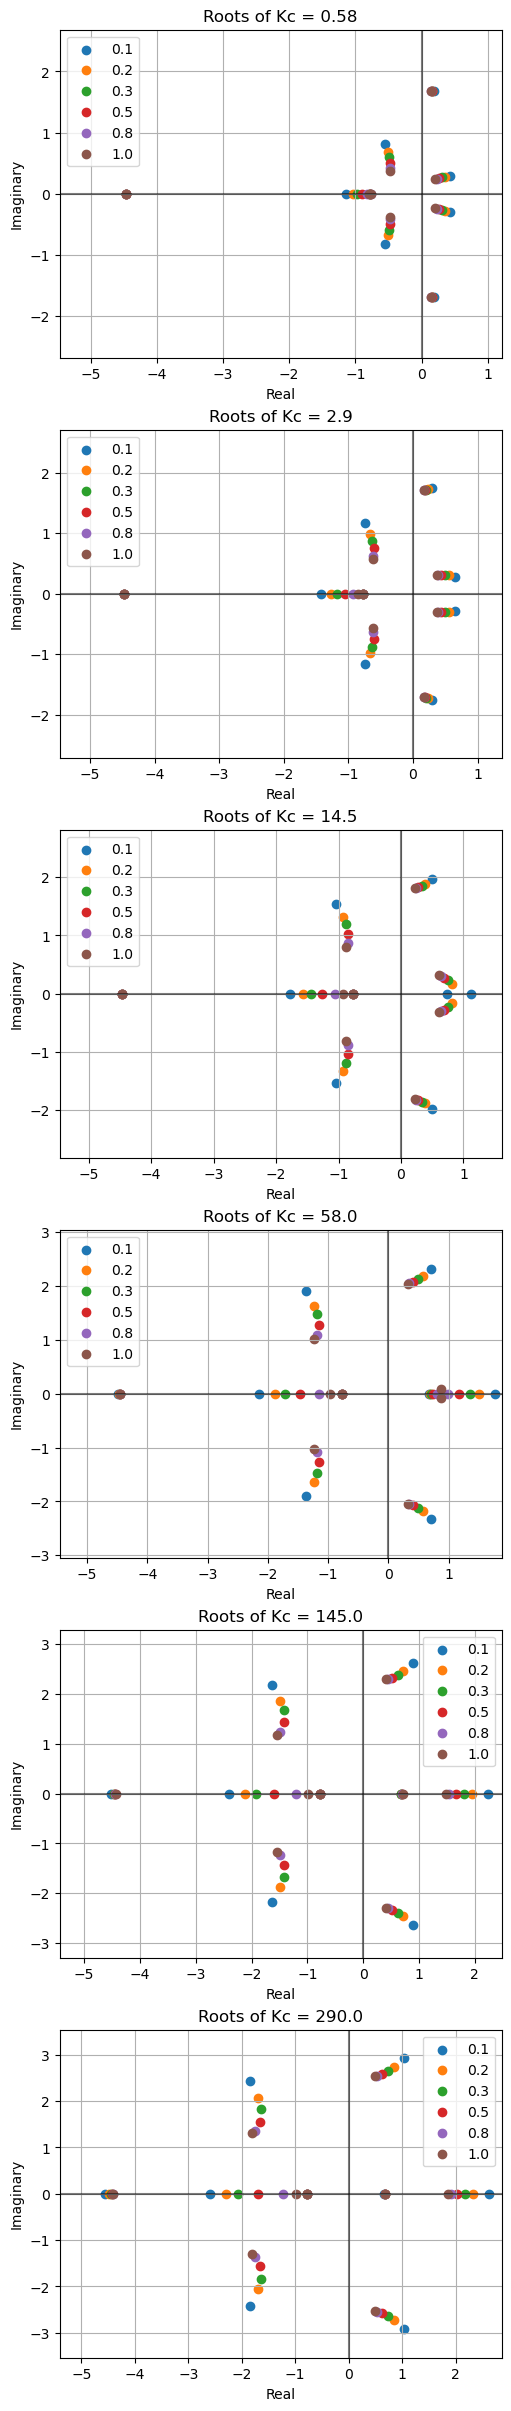

In [5]:
fig , axs = plt.subplots(6, 1, figsize=(5, 24), layout='constrained')
i = 0
for Kc in results.keys():
    for tau_i in results[Kc].keys():
        x = results[Kc][tau_i].real
        y = results[Kc][tau_i].imag

        axs[i].scatter(x, y, label=f"{tau_i}")

    axs[i].plot([min(x)-1, max(x)+1], [0, 0], color="black", alpha=0.5)
    axs[i].plot([0, 0], [min(y)-1, max(y)+1], color="black", alpha=0.5)
    axs[i].set_xlim(left=min(x)-1, right=max(x)+1)
    axs[i].set_ylim(top=max(y)+1, bottom=min(y)-1)
    axs[i].grid(True)
    axs[i].set_title(f"Roots of Kc = {Kc}")
    axs[i].legend(fontsize="10")
    axs[i].set_xlabel("Real")
    axs[i].set_ylabel("Imaginary")
    i = i+1